In [1]:
using Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using LTBonds 
using Plots
using BenchmarkTools
using LaTeXStrings 

  Activating environment at `~/Github/floating-rate-debt/Project.toml`


In [2]:
modelLB, modelSB, modelLB2 = map((0.05, 1.0, 0.025)) do λ
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 200, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = (λ < 0.05 ? 0.006 : 0.003), span = 2.0)
    bond = BondCE2012(n = 350, min = 0.0, max = 1.5, κ = 0.03, λ = λ)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    generate_workspace(LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R
    ))
end;

In [3]:
for m in (modelLB, modelSB, modelLB2)
    @time solve!(m; max_iters = 1500, g = 1.0, err = 1e-10, print_every = 50)
end 

1: (v = 1.6294201606822334, q = 0.8755531659789029, vD = 0.5716845187082242)
51: (v = 0.022894135081294564, q = 0.4137348667667613, vD = 0.004487160557040681)
101: (v = 0.006557750062114565, q = 0.06909270629576592, vD = 0.0031700126553708685)
151: (v = 0.0015907983741172416, q = 0.020364971203709947, vD = 0.0008068096435387417)
201: (v = 0.0003045518538122849, q = 0.0025652407606600036, vD = 0.0001641313942748468)
251: (v = 4.5058486385585184e-5, q = 0.0002611590371112138, vD = 3.2218110771253805e-5)
301: (v = 6.87454519976427e-6, q = 3.2776627257868896e-5, vD = 5.2843102587019075e-6)
351: (v = 1.015088365363681e-6, q = 4.233018395582988e-6, vD = 8.114223390975894e-7)
401: (v = 1.4453216934384727e-7, q = 5.655740719090474e-7, vD = 1.1770399055421876e-7)
451: (v = 2.0176162962570743e-8, q = 7.644986110832974e-8, vD = 1.657967629853374e-8)
501: (v = 2.7885143083494768e-9, q = 1.0395353244874173e-8, vD = 2.3016397676656197e-9)
551: (v = 3.8347280906236847e-10, q = 1.4181056329221065e-9, 

## Figures

In [4]:
#to set spacing of markers and other attributes
@recipe function f(::Type{Val{:samplemarkers}}, x, y, z; step = 10)
    n = length(y)
    sx, sy = x[1:step:n], y[1:step:n]
    # add an empty series with the correct type for legend markers
    @series begin
        seriestype := :path
        markershape --> :auto
        x := []
        y := []
    end
    # add a series for the line
    @series begin
        primary := false # no legend entry
        markershape := :none # ensure no markers
        seriestype := :path
        seriescolor := get(plotattributes, :seriescolor, :auto)
        x := x
        y := y
    end
    # return  a series for the sampled markers
    primary := false
    seriestype := :scatter
    markershape --> :auto
    x := sx
    y := sy
end

In [5]:
function plot_q(idx,a1,a2,a3)
    #set linewidth for plots:
    lw = 2
    ms = 3
    default(size = (600,400), xtickfontsize = 12, ytickfontsize = 12, yguidefontsize = 14, xguidefontsize = 14)
    msdiamond = 5

    qstar1, qstar2, qstar3 = map(risk_free_price ∘ get_base_pars, (a1, a2, a3))
    b_grid1, b_grid2, b_grid3 = map(get_b_grid, (a1, a2, a3))
    q1, q2, q3 = map(get_q, (a1, a2, a3))

    f = plot(b_grid1, q1[:, idx]./qstar1, line = (lw, :black), legend = false, xlabel = (L"$b'$"), ylabel = (L"$q(b',y=y_{min})/q^{RF}$"))
    plot!(f, b_grid2, q2[:, idx]./qstar2, line = (lw,:dash, :black),st = :samplemarkers, step = 20, markercolor=:black, shape = :circle, markersize = ms)
    plot!(f, b_grid3, q3[:, idx]./qstar3, line = (lw,:dashdot, :black),st = :samplemarkers, step = 20, markercolor=:black, shape = :diamond, markersize = msdiamond)

    plot!(f, xlims = (0, b_grid1[end]))
    return f
end

plot_q (generic function with 1 method)

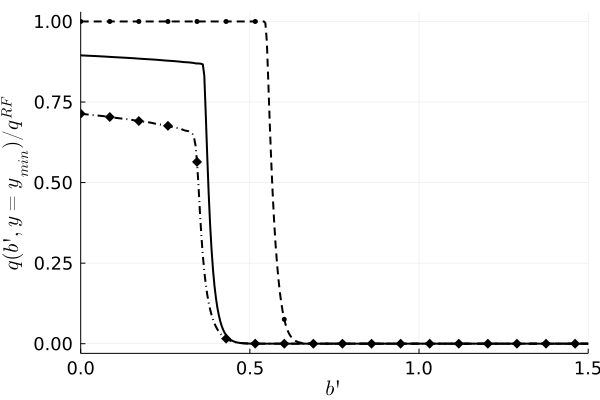

In [6]:
#plot prices at lowest Y (Figure 7-6 (a))
plot_q(1, modelLB, modelSB, modelLB2)

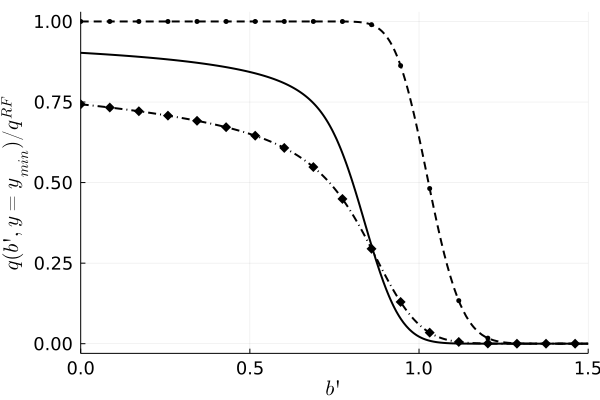

In [7]:
#plot prices at mean Y (Figure 7-6 (b))
midY = length(get_y_grid(modelLB)) ÷ 2
plot_q(midY, modelLB, modelSB, modelLB2)

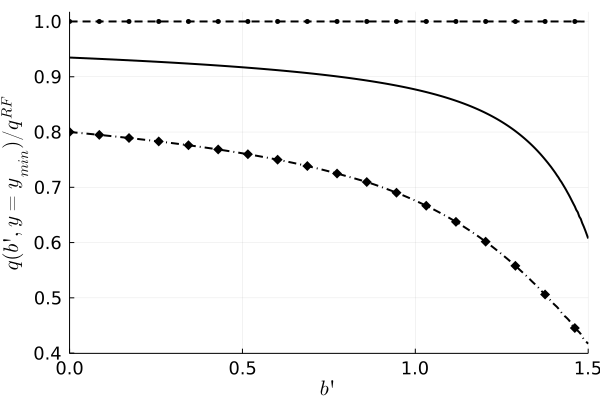

In [8]:
#plot prices at max Y (Figure 7-6 (c))
plot_q(length(get_y_grid(modelLB)), modelLB, modelSB, modelLB2)